In [665]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [666]:
sub_process_names = [
    'Effluent treatment',
    'Li recovery',
    'Ni recovery',
    'Co recovery',
    'Mn recovery',
    'Solution purification',
    'Leaching',
    'Total'
]

In [667]:
def parse_contribution_tree(scenario):
    # Read the Excel file into a DataFrame
    df = pd.read_excel('contribution_tree.xlsx', 'Upstream tree')

    # Get the impact category and unit as the dataset name
    labels = df.columns[0].split(':')
    category = ','.join(labels[1:])[1:]
    unit = df.iloc[0][8]
    unit = unit[unit.find('[')+1:unit.find(']')]
    unit = ''.join(['[', unit, ']'])
    name = ''.join([category, ' ', unit])

    # Initialize variables
    processes = []
    final_rows = []
    current_subprocess_level = -1

    # Iterate through the rows of the dataframe
    for i, row in df.iterrows():
        # Replace nan by 0 in 'Direct contributions' column
        if pd.isna(row.iloc[-1]):
            row.iloc[-1] = 0

        # Determine the level by checking which cell is filled in the row
        level = next((j for j in range(len(row)) if not pd.isna(row[j])), len(row))
        if level == current_subprocess_level:
            current_subprocess_level -= 1

        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            current_subprocess_level = level
            row['Level'] = level
            final_rows.append(row.dropna().values)

        # Check if the row is an activity and needs to be retained
        elif not pd.isna(row[level]):
            # Check if the activity is directly under a subprocess
            if level - 1 == current_subprocess_level:
                # Direct child of a subprocess
                row['Level'] = level
                final_rows.append(row.dropna().values)

    # Create a new DataFrame from the filtered rows
    final_rows[0][-1] = 'Level'
    final_df = pd.DataFrame(final_rows)
    final_df.columns = final_df.iloc[0]
    final_df = final_df[1:]

    return name, final_df

In [668]:
def parse_sub_processes(df, sub_process_names):
    sub_process_totals = []
    sub_processes = []

    # Extract sub-process 'totals' (e.g. 'Leaching')
    for i, row in df.iterrows():
        # print(row['Level'])
        # print(sub_process_names[7 - row['Level']])
        df.loc[i, 'Sub-process'] = sub_process_names[row['Level'] - 1]
        if row[0].startswith('Baseline'):
            sub_process_totals.append(row)
            df.drop(index=i, inplace=True)
    sub_process_totals = pd.DataFrame(sub_process_totals, columns=df.columns)
    
    # Group sub-processes
    for i, g in df.groupby('Level'):
        sub_processes.append(g)
    
    return sub_process_totals, sub_processes

In [672]:
def parse_process_names(processes):
    for p in processes:
        for i, row in p.iterrows():
            split_row = row[0].split(' | ')
            p.loc[i, 'Processes'] = split_row[0]
            if row[0].startswith('market for'):
                p.loc[i, 'Processes'] = row[0][11:]
            if row[0].startswith('market group for'):
                p.loc[i, 'Processes'] = row[0][17:]
            if row[0].endswith('production'):
                p.loc[i, 'Processes'] = row[0][:-11]

    return processes

In [686]:
category, contributions = parse_contribution_tree('Baseline')
sub_process_totals, sub_processes = parse_sub_processes(contributions, sub_process_names)

c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [674]:
sub_processes[6]

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
27,"market for hydrogen peroxide, without water, i...",0.0,0,7,Leaching
28,market for sulfuric acid | sulfuric acid | Cut...,0.0,0,7,Leaching
29,"market group for electricity, medium voltage |...",0.0,0,7,Leaching
30,market group for tap water | tap water | Cutof...,0.0,0,7,Leaching


In [675]:
category

'Human toxicity, carcinogenic, inorganics [CTUh]'

In [687]:
parsed = parse_process_names(sub_processes)

In [677]:
parsed[6]

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
27,"hydrogen peroxide, without water, in 50% solut...",0.0,0,7,Leaching
28,sulfuric acid,0.0,0,7,Leaching
29,"electricity, medium voltage",0.0,0,7,Leaching
30,tap water,0.0,0,7,Leaching


In [688]:
combined_df = pd.concat(sub_processes)
combined_df

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
2,"hazardous waste, for underground deposit",0.0,0,1,Effluent treatment
3,"electricity, medium voltage",0.0,0,1,Effluent treatment
4,"wastewater, average",0.0,0.0,1,Effluent treatment
5,"quicklime, milled, packed",0.0,0,1,Effluent treatment
6,tap water,0.0,0,1,Effluent treatment
7,"wastewater, unpolluted",0.0,0,1,Effluent treatment
9,"soda ash, dense",0.0,0,2,Li recovery
10,"electricity, medium voltage",0.0,0,2,Li recovery
11,tap water,0.0,0,2,Li recovery
12,"sodium sulfate, anhydrite",-0.0,0,2,Li recovery


In [691]:
pivot_df = combined_df.pivot(index='Sub-process', columns='Processes', values=combined_df.columns[1]).fillna(0)

# Write here all the processes you want to omit from the figure
dropped = [
    'nickel sulfate'
]

# Comment or uncomment the following line to plot all or only those w\o 'dropped'
# pivot_df.drop(['nickel sulfate', 'cobalt sulfate'], axis=1, inplace=True)

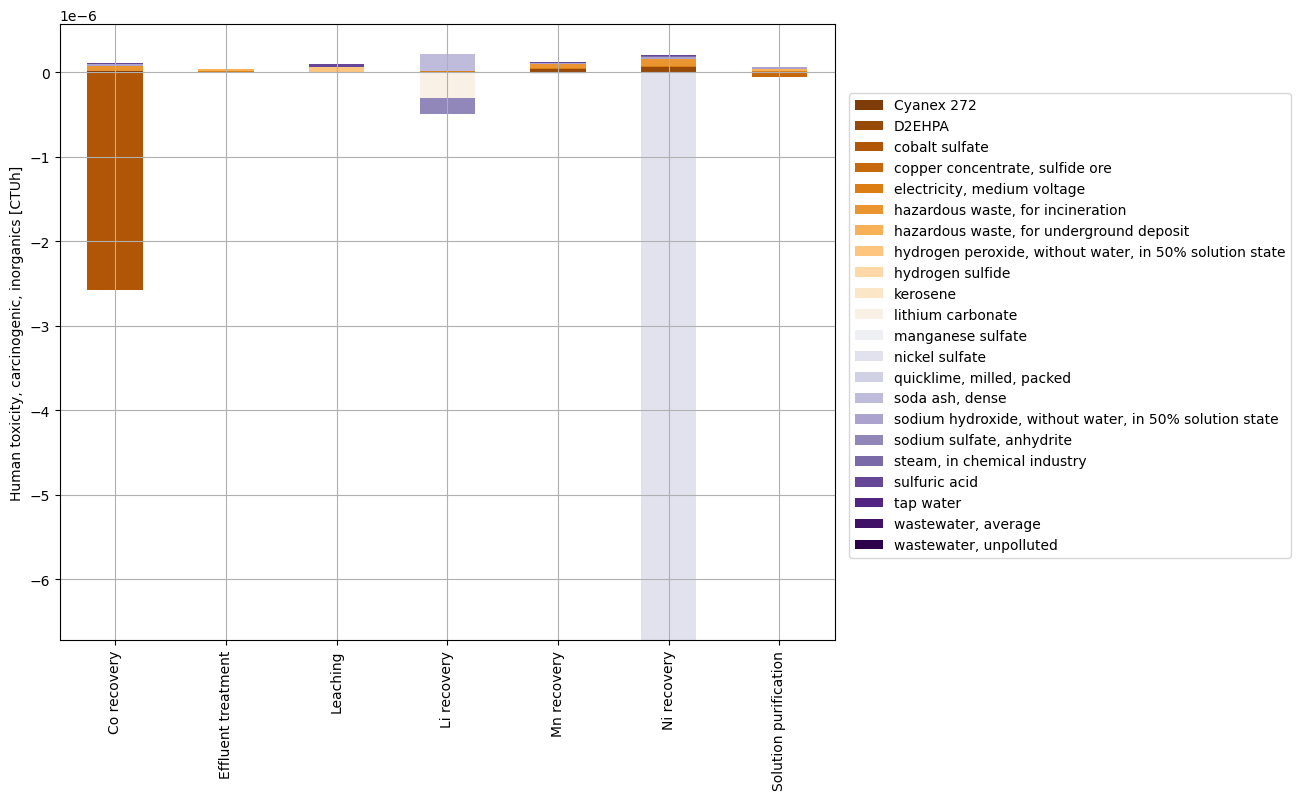

In [705]:
fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.get_cmap('PuOr')
# cmaplist = [cmap[i] for i in range(cmap.N)]
# cmap = cmap.from_list('Custom map', cmaplist, cmap.N)
bounds = np.arange(np.min(pivot_df.values), np.max(pivot_df.values), 0.5)
idx = np.searchsorted(bounds, 0)
bounds = np.insert(bounds, idx, 0)
norm = BoundaryNorm(bounds, cmap.N)

pivot_df.plot.bar(stacked=True, grid=True, ax=ax, cmap=cmap)
plt.legend(bbox_to_anchor=(1.01, 0.9))
plt.xlabel('')
plt.ylabel(category)

plt.show()